# Book Clustering Statistics

This notebook provides statistics on the results of our book clustering.

## Setup

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as pn
import polars as pl

## Load Data

Let’s start by getting our clusters and their statistics:

In [2]:
clusters = pd.read_parquet("book-links/cluster-stats.parquet")
clusters.set_index("cluster", inplace=True)

Describe the count columns for basic descriptive stats:

In [3]:
clusters.describe().T

75% of clusters only contain 2 ISBNs (probably -10 and -13) and one
book. OpenLibrary also contributes to the largest number of clusters.

## Clusters per Source

How many clusters are connected to each source?

In [4]:
src_counts = (clusters > 0).sum().to_frame("count")
src_counts.index.name = "source"
src_counts

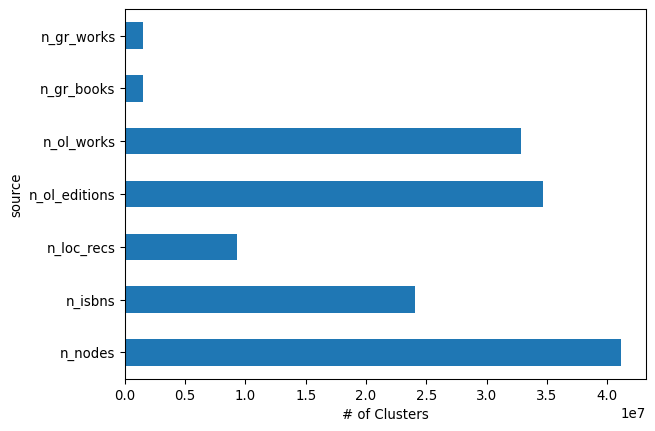

In [5]:
src_counts["count"].plot.barh()
plt.xlabel("# of Clusters")
plt.show()

## Distributions

Let’s look at the distributions of cluster sizes. Let’s first compute
histograms of the number of records per cluster for each cluster type.

In [6]:
size_dists = pd.concat(
    {src: clusters.loc[clusters[src] > 0, src].value_counts() for src in clusters.columns},
    names=["source", "records"],
)
size_dists = size_dists.to_frame("count").reset_index()

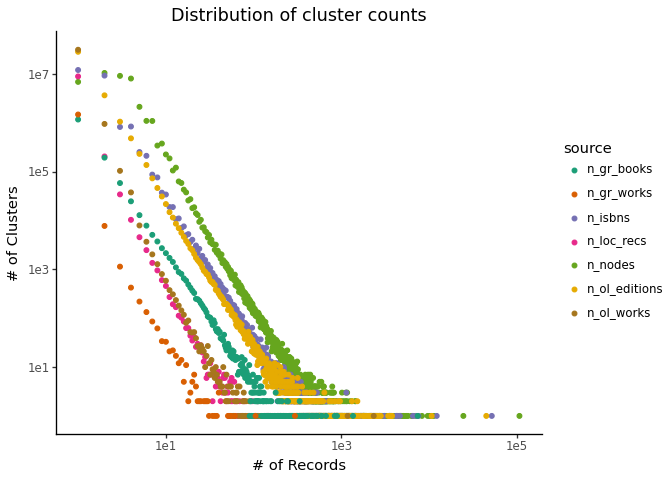

In [7]:
(
    pn.ggplot(size_dists)
    + pn.aes(x="records", y="count", color="source")
    + pn.geom_point()
    + pn.scale_x_log10()
    + pn.scale_y_log10()
    + pn.scale_color_brewer(type="qual", palette="Dark2")
    + pn.xlab("# of Records")
    + pn.ylab("# of Clusters")
    + pn.ggtitle("Distribution of cluster counts")
    + pn.theme_classic()
)

Looks mostly fine - we expect a lot of power laws - but the number of
clusters with merged GoodReads works is concerning.

## GoodReads Work Merging

What’s going on with these clusters? Let’s take a peek at them.

In [8]:
gr_big = clusters[clusters["n_gr_works"] > 1].sort_values("n_gr_works", ascending=False)

We have a lot of these clusters. What fraction of the GoodReads-affected
clusters is this?

In [9]:
len(gr_big) / np.sum(clusters["n_gr_books"] > 0).item()

0.006696677703783623

Less than 1%. Not bad, but let’s look at these largest clusters.

In [10]:
gr_big.head()